<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/HCMtest006-trainall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/TEST/UnetFold7-alltrain.h5", compile=False)

In [7]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:


val_img_path = "/gdrive/MyDrive/TESI/TEST/test6/test_images"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/test6/test_masks"

In [9]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


img_data_gen_args = dict(rescale=1./255,
                     rotation_range=90,
                     brightness_range=[0.3,0.9],
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant')

mask_data_gen_args = dict(
                     rotation_range=90,
                     brightness_range=[0.3,0.9],
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                     
                     ) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

In [10]:
batch_size=16

In [26]:


valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                           seed=seed, 
                                                           batch_size=255,
                                                           color_mode = 'grayscale',           
                                                           target_size=(256,256),         
                                                           
                                                           class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                                      seed=seed, 
                                                           batch_size=255,
                                                           color_mode = 'grayscale',           
                                                           target_size=(256,256),         
                                                           class_mode=None)  #Default batch size 32, if not specified here

val_generator = zip(valid_img_generator, valid_mask_generator)

Found 223 images belonging to 1 classes.
Found 223 images belonging to 1 classes.


In [29]:
a,b=val_generator.__next__()

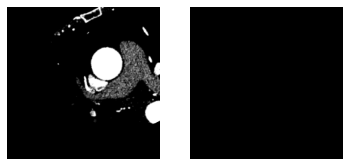

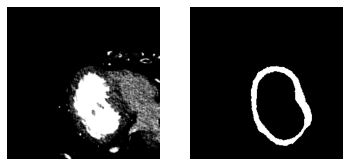

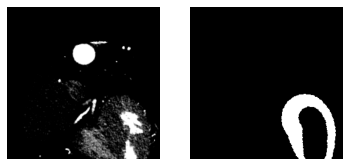

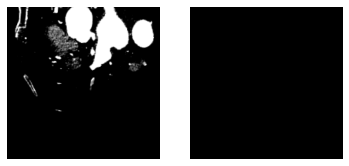

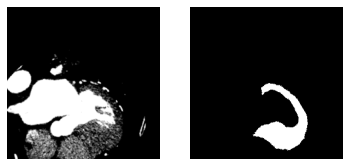

In [30]:
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

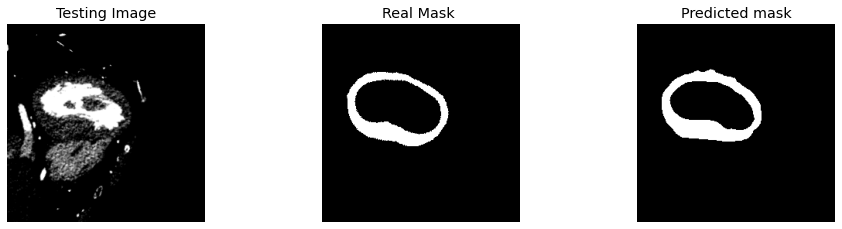

In [109]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')

plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [85]:

#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83439004


In [68]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1.0
0.82250947
0.4695809
1.0
0.78169143
1.0
0.8468698
0.6109737
0.8833361
0.49967194
1.0
0.7752167
1.0
1.0
1.0
0.8421005
1.0
1.0
1.0
0.6765716
1.0
0.49891663
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8232864
1.0
0.6707315
0.455101
0.88404197
1.0
0.8596277
1.0
1.0
1.0
0.5751483
0.8251847
1.0
1.0
1.0
0.8430742
0.82297146
0.8347935
0.49829865
1.0
1.0
0.8512025
1.0
1.0
0.46503448
1.0
1.0
1.0
1.0
0.86686605
1.0
1.0
1.0
1.0
1.0
0.49345398
1.0
0.8753576
0.8168304
1.0
1.0
1.0
1.0
0.8921838
1.0
0.77004856
1.0
1.0
1.0
0.49999237
0.49028778
1.0
1.0
1.0
0.4999771
1.0
1.0
1.0
1.0
0.8488246
1.0
0.8758483
1.0
1.0
0.8502405
1.0
0.83439004
1.0
1.0
0.8755372
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.7223493
0.8834375
1.0
0.46938324
0.80484194
1.0
0.4636078
1.0
1.0
1.0
1.0
1.0
1.0
0.46162415
1.0
0.85125023
0.7424917
1.0
0.86169374
0.6168978
0.81148154
1.0
1.0
1.0
1.0
0.8293632
0.8808481
1.0
0.45700073
1.0
1.0
1.0
0.49983215
0.87837946
1.0
0.8284207
0.88596
1.0
0.7414491
1.0
0.49438477
1.0
0.8711648
1